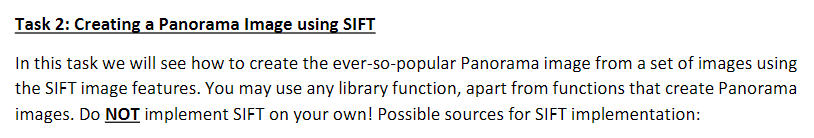

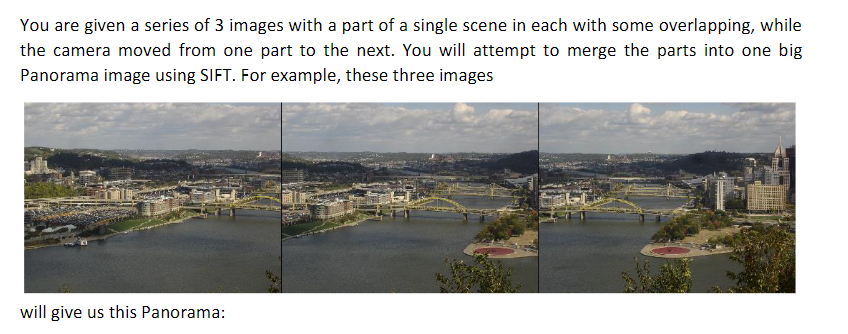

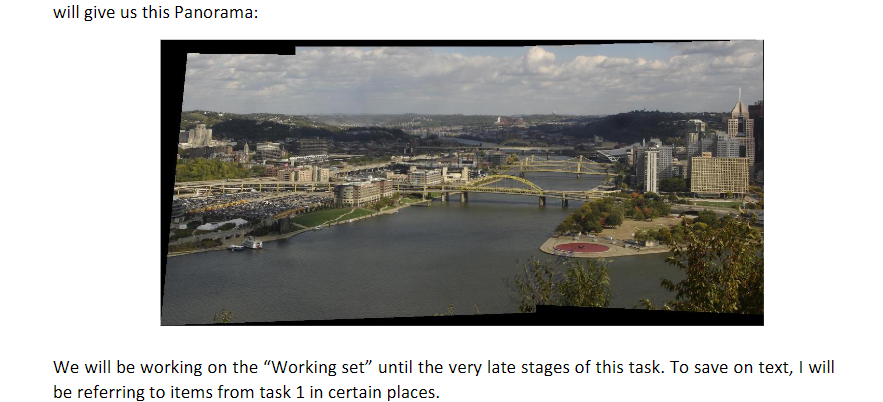

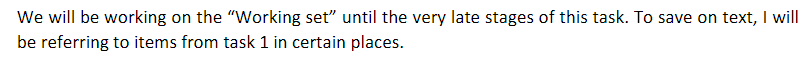

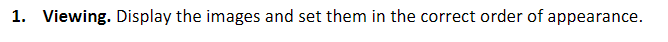

In [179]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

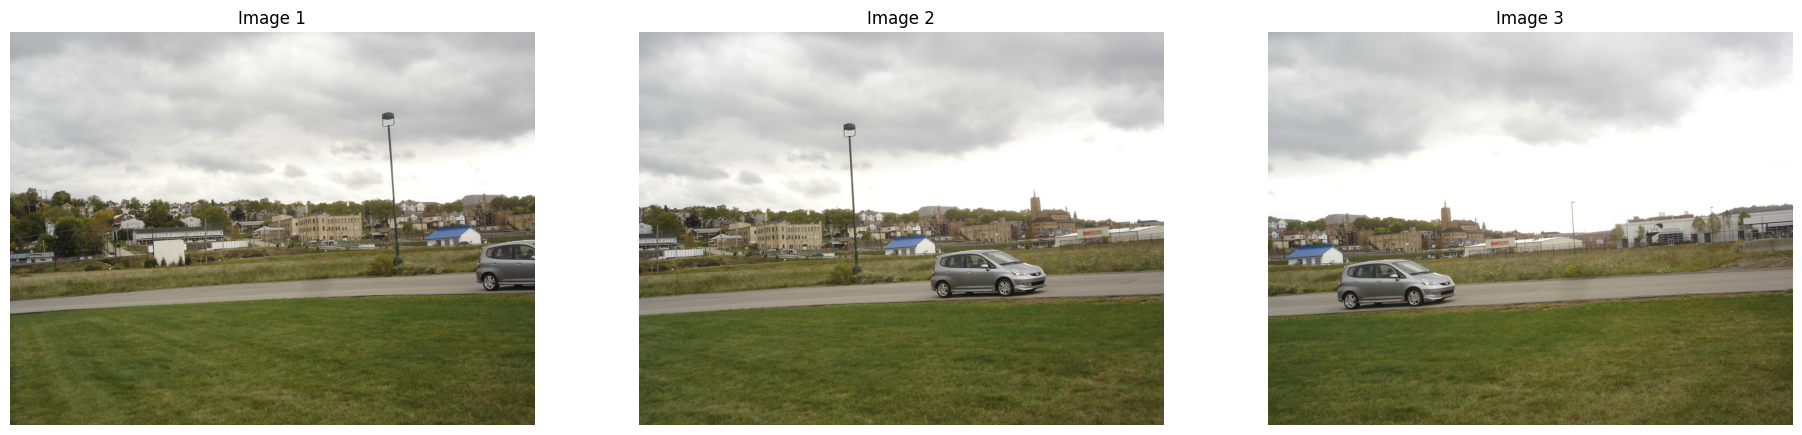

In [180]:
# Load images
img1 = cv2.imread('Q2/Working set/I1.jpg')
img2 = cv2.imread('Q2/Working set/I2.jpg')
img3 = cv2.imread('Q2/Working set/I3.jpg')

# Convert to RGB for displaying with matplotlib
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3_rgb = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

# Display images
plt.figure(figsize=(23,17))
plt.subplot(131), plt.imshow(img1_rgb), plt.title('Image 1')
plt.axis('off')
plt.subplot(132), plt.imshow(img2_rgb), plt.title('Image 2')
plt.axis('off')
plt.subplot(133), plt.imshow(img3_rgb), plt.title('Image 3')
plt.axis('off')
plt.show()

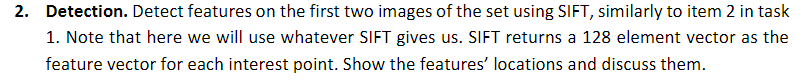

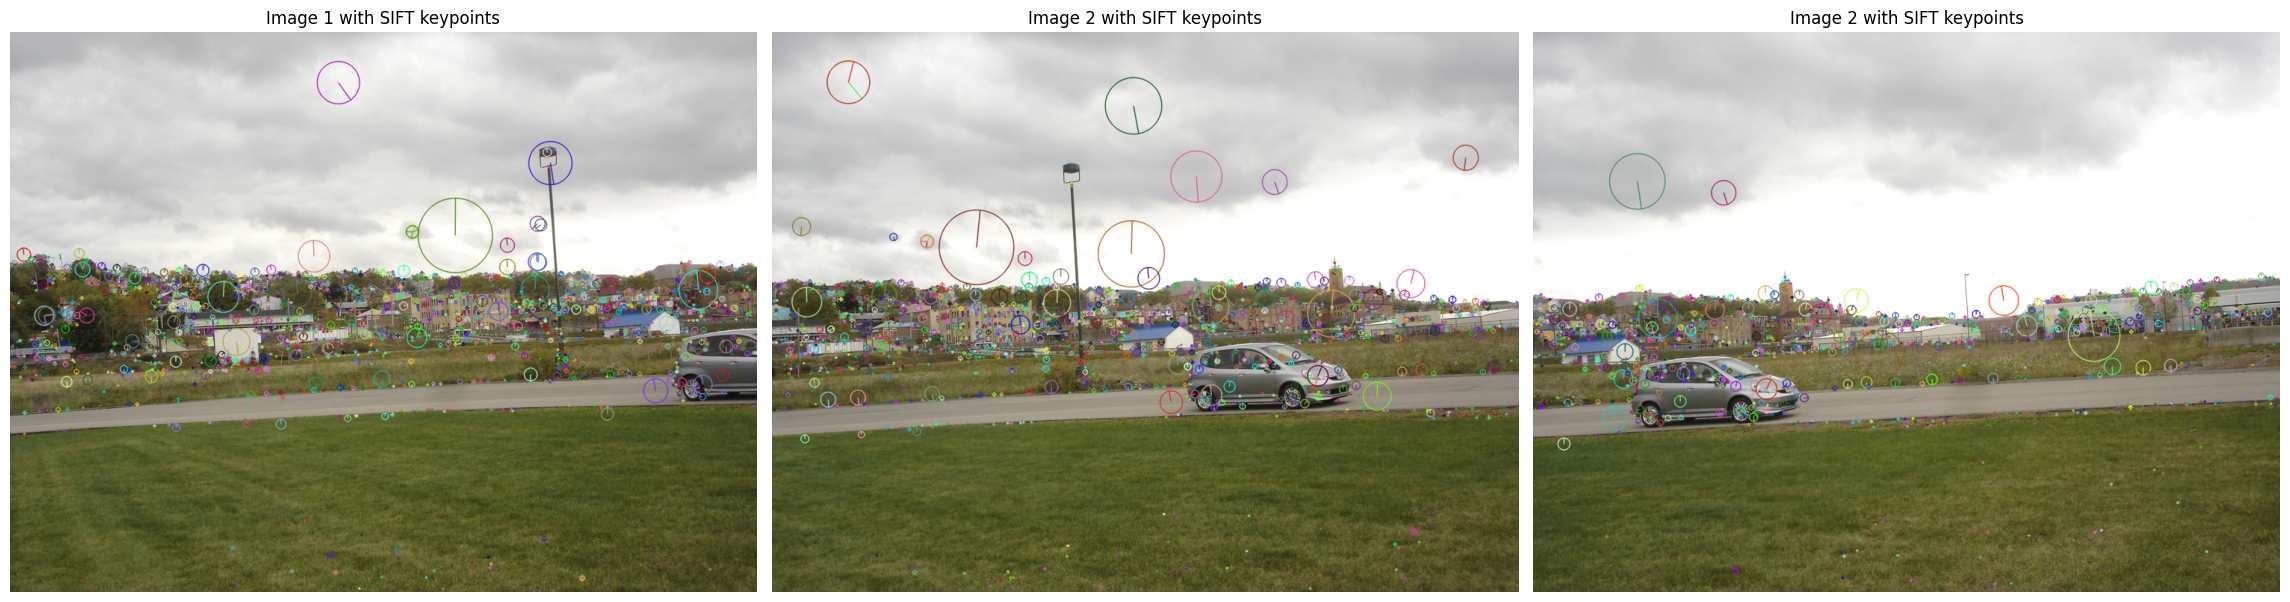

In [181]:
# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect SIFT features and compute descriptors
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)
keypoints3, descriptors3 = sift.detectAndCompute(img3, None)

# Draw keypoints on the images
img1_keypoints = cv2.drawKeypoints(img1, keypoints1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_keypoints = cv2.drawKeypoints(img2, keypoints2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img3_keypoints = cv2.drawKeypoints(img3, keypoints3, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


# Convert to RGB for displaying with matplotlib
img1_keypoints_rgb = cv2.cvtColor(img1_keypoints, cv2.COLOR_BGR2RGB)
img2_keypoints_rgb = cv2.cvtColor(img2_keypoints, cv2.COLOR_BGR2RGB)
img3_keypoints_rgb = cv2.cvtColor(img3_keypoints, cv2.COLOR_BGR2RGB)

# Display images with keypoints
fig, axes = plt.subplots(1, 3, figsize=(23, 17))
axes[0].imshow(img1_keypoints_rgb, cmap='gray')
axes[0].set_title('Image 1 with SIFT keypoints')
axes[0].axis('off')

axes[1].imshow(img2_keypoints_rgb, cmap='gray')
axes[1].set_title('Image 2 with SIFT keypoints')
axes[1].axis('off')

axes[2].imshow(img3_keypoints_rgb, cmap='gray')
axes[2].set_title('Image 2 with SIFT keypoints')
axes[2].axis('off')
plt.tight_layout()
plt.show()


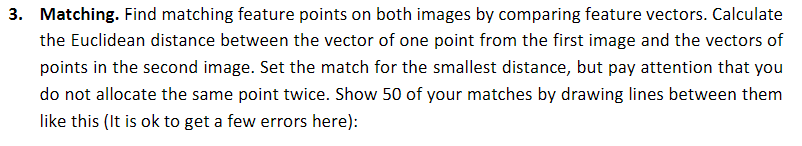

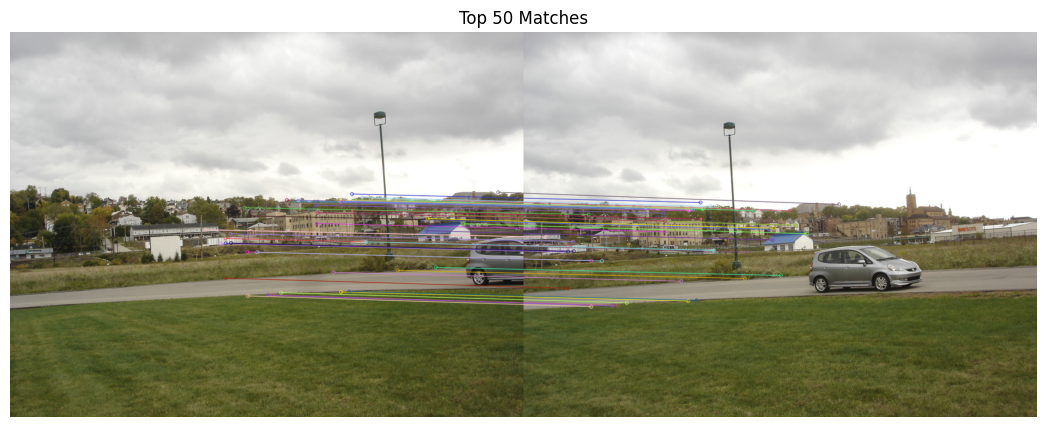

In [182]:
# Initialize BFMatcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors
matches1_2 = bf.match(descriptors1, descriptors2)

# Match descriptors between image 2 and image 3
matches2_3 = bf.match(descriptors2, descriptors3)

# Sort matches by distance
matches1_2 = sorted(matches1_2, key=lambda x: x.distance)

# Match descriptors between image 2 and image 3
matches2_3 = bf.match(descriptors2, descriptors3)

# Sort matches by distance
matches2_3 = sorted(matches2_3, key=lambda x: x.distance)

# Draw top 50 matches
img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches1_2[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Convert to RGB for displaying with matplotlib
img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)

# Display matches
plt.figure(figsize=(15,5))
plt.imshow(img_matches_rgb), plt.title('Top 50 Matches')
plt.axis('off')
plt.show()


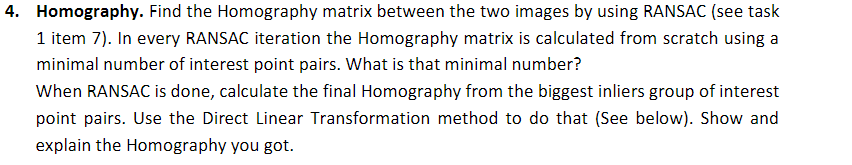

In RANSAC (Random Sample Consensus), the minimal number of interest point pairs required to compute the Homography matrix is 4. This is because the Homography matrix 
𝐻
H is a 3x3 matrix with 8 degrees of freedom (since it's defined up to scale). To uniquely determine 
𝐻
H, you need at least 4 corresponding points in both images

Step 1: Compute SIFT keypoints and descriptors
First, you'll compute SIFT keypoints and descriptors for both images (img1 and img2)

In [183]:
# Extract location of good matches
points1 = np.zeros((len(matches1_2), 2), dtype=np.float32)
points2 = np.zeros((len(matches1_2), 2), dtype=np.float32)

for i, match in enumerate(matches1_2):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt
    
# Extract location of good matches
points2_3_1 = np.zeros((len(matches2_3), 2), dtype=np.float32)
points2_3_2 = np.zeros((len(matches2_3), 2), dtype=np.float32)

for i, match in enumerate(matches2_3):
    points2_3_1[i, :] = keypoints2[match.queryIdx].pt
    points2_3_2[i, :] = keypoints3[match.trainIdx].pt
    

# Find homography matrix using RANSAC
homography, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

# Print homography matrix
print("Homography Matrix:(Image 1 to Image 2)\n", homography)


# Find homography matrix using RANSAC
homography2_3, mask2_3 = cv2.findHomography(points2_3_1, points2_3_2, cv2.RANSAC)

# Print homography matrix
print("Homography Matrix (Image 2 to Image 3):\n", homography2_3)

Homography Matrix:(Image 1 to Image 2)
 [[ 1.19860462e+00 -1.78463799e-02 -4.02386775e+02]
 [ 9.18980410e-02  1.12763043e+00 -4.05352700e+01]
 [ 2.04450200e-04 -1.18545491e-05  1.00000000e+00]]
Homography Matrix (Image 2 to Image 3):
 [[ 1.26505572e+00 -1.66701078e-02 -5.43165099e+02]
 [ 1.18620513e-01  1.18751293e+00 -6.20372452e+01]
 [ 2.69761635e-04 -8.29994009e-06  1.00000000e+00]]


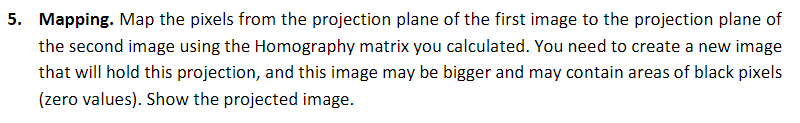

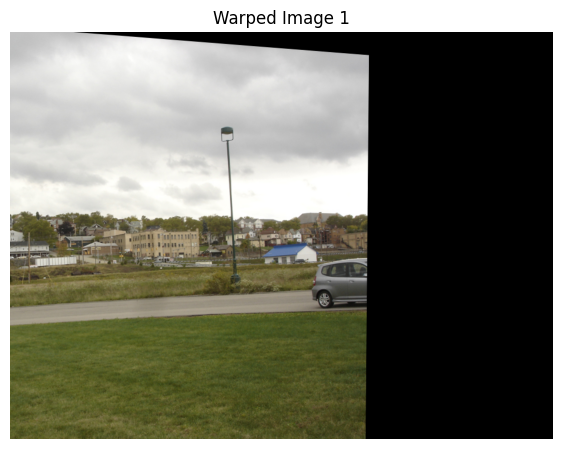

In [184]:
# Warp the first image to the second image's plane
height, width, channels = img2.shape
img1_warped = cv2.warpPerspective(img1, homography, (width, height))

# Warp the second image to the third image's plane
img2_warped = cv2.warpPerspective(img2, homography2_3, (img3.shape[1], img3.shape[0]))

# Display the warped image
img1_warped_rgb = cv2.cvtColor(img1_warped, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(7,13))
plt.imshow(img1_warped_rgb), plt.title('Warped Image 1')
plt.axis('off')
plt.show()


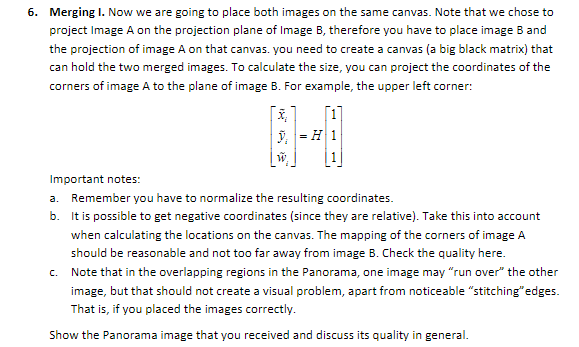

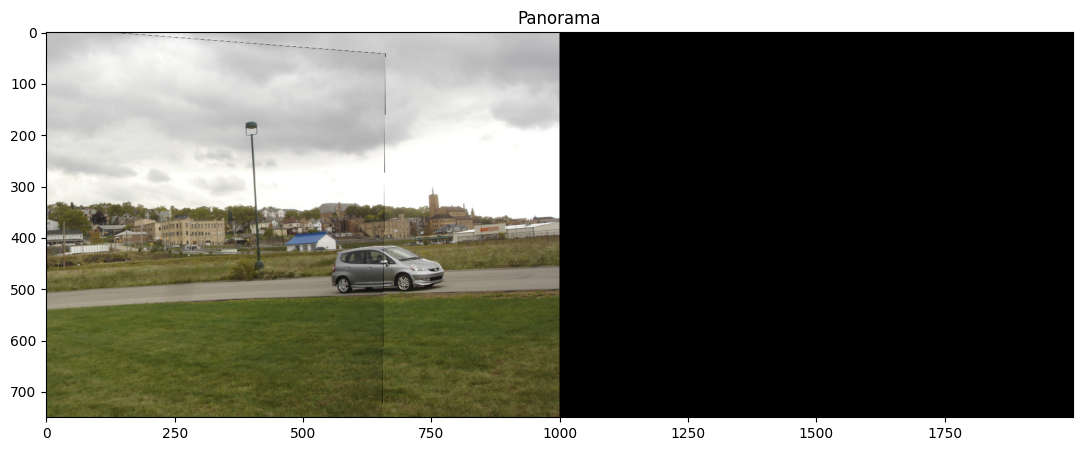

In [190]:
# Create a black canvas that can fit all three images
import itertools
canvas_width = img3.shape[1] + img2_warped.shape[1]
canvas_height = img3.shape[0]
canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)

# Place the second image on the canvas
canvas[:img2.shape[0], :img2.shape[1]] = img2



# Place the warped first image on the canvas
for i, j in itertools.product(range(img1_warped.shape[0]), range(img1_warped.shape[1])):
    if img1_warped[i, j].any():
        canvas[i, j] = img1_warped[i, j]

# Convert to RGB for displaying with matplotlib
canvas_rgb = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)

# Display the panorama
plt.figure(figsize=(15,5))
plt.imshow(canvas_rgb), plt.title('Panorama')
plt.show()


In [186]:
def gaussian_kernel(size, sigma=1):
    """Generates a 2D Gaussian kernel."""
    kernel_1d = np.linspace(-(size // 2), size // 2, size)
    x, y = np.meshgrid(kernel_1d, kernel_1d)
    kernel = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))
    return kernel / np.sum(kernel)

def convolve(image, kernel):
    """Convolves an image with a given kernel."""
    k = kernel.shape[0] // 2
    padded_image = np.pad(image, k, mode='edge')
    convolved_image = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i + kernel.shape[0], j:j + kernel.shape[1]]
            convolved_image[i, j] = np.sum(region * kernel)
    return convolved_image

def downsample(image):
    """Downsamples the image by a factor of 2."""
    return image[::2, ::2]

def upsample(image):
    """Upsamples the image by a factor of 2."""
    upsampled = np.zeros((image.shape[0] * 2, image.shape[1] * 2), dtype=image.dtype)
    upsampled[::2, ::2] = image
    kernel = gaussian_kernel(5, sigma=1)
    return convolve(upsampled, kernel)

def gaussian_pyramid(image, levels):
    gp = [image]
    for _ in range(1, levels):
        image = downsample(convolve(image, gaussian_kernel(5, sigma=1)))
        gp.append(image)
    return gp

def laplacian_pyramid(gp):
    lp = []
    for i in range(len(gp) - 1):
        GE = upsample(gp[i + 1])
        if GE.shape != gp[i].shape:
            GE = GE[:gp[i].shape[0], :gp[i].shape[1]]
        L = gp[i] - GE
        lp.append(L)
    lp.append(gp[-1])
    return lp

def reconstruct_image(lp):
    image = lp[-1]
    for i in range(len(lp) - 2, -1, -1):
        image = upsample(image)
        if image.shape != lp[i].shape:
            image = image[:lp[i].shape[0], :lp[i].shape[1]]
        image = image + lp[i]
    return image

def pyramid_blending(A, B, mask, levels):
    gpA = gaussian_pyramid(A, levels)
    gpB = gaussian_pyramid(B, levels)
    gpM = gaussian_pyramid(mask, levels)

    lpA = laplacian_pyramid(gpA)
    lpB = laplacian_pyramid(gpB)

    LS = [la * lm + lb * (1.0 - lm) for la, lb, lm in zip(lpA, lpB, gpM)]
    return reconstruct_image(LS)

